In [41]:
from jax_md import space, energy, simulate

import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition

from functools import partial
import time

f32 = np.float32
f64 = np.float64

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
#import seaborn as sns 
#sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = np.triu(np.where(dr<dr_cutoff, 1, 0)) - np.eye(R.shape[0],dtype=np.int32)
  index_list=np.dstack(np.meshgrid(np.arange(N), np.arange(N), indexing='ij'))

  i_s = np.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = np.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = np.transpose(np.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=np.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=np.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(np.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

In [33]:
# Global variables
N = 64
BOX_SIZE = 8
L = BOX_SIZE
T = 2
mass = 1.0
dt = 0.003
RC = 2.5
sigma = 1.123  
V = BOX_SIZE ** 3

In [34]:
displacement, shift = space.periodic(BOX_SIZE)

In [63]:
def vanderwaals(r, rc=RC):
    v = 4 * ((1 / r) ** 12 - (1 / r) ** 6)
    vc = 4 * ((1 / rc) ** 12 - (1 / rc) ** 6)
    return v - vc

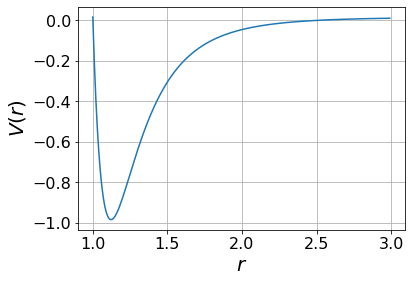

In [56]:
drs = np.arange(1,3,0.01)
U = vanderwaals(drs)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

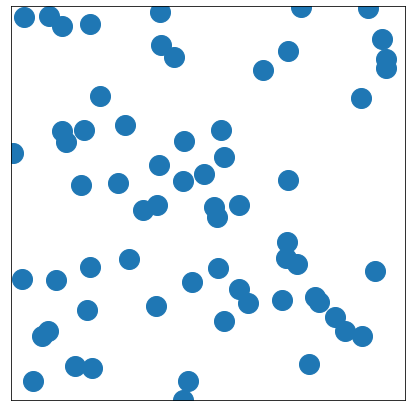

In [57]:
key, split = random.split(key)
R = random.uniform(split, (N, 3), minval=0.0, maxval=BOX_SIZE, dtype=f64)

plot_system(R, BOX_SIZE)

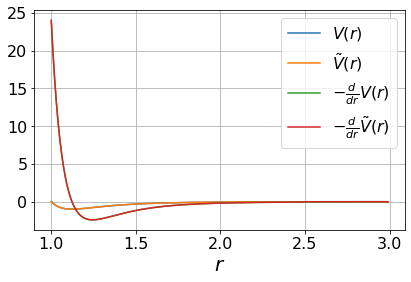

In [70]:
vanderwaals_cutoff = energy.multiplicative_isotropic_cutoff(
    vanderwaals, r_onset=RC-0.01, r_cutoff=RC)

dr = np.arange(1,3,0.01)
V = vanderwaals(dr)
V_cutoff = vanderwaals_cutoff(dr)
F = -vmap(grad(vanderwaals))(dr)
F_cutoff = -vmap(grad(vanderwaals_cutoff))(dr)
plt.plot(dr,V, label=r'$V(r)$')
plt.plot(dr,V_cutoff, label=r'$\tilde V(r)$')
plt.plot(dr,F, label=r'$-\frac{d}{dr} V(r)$')
plt.plot(dr,F_cutoff, label=r'$-\frac{d}{dr} \tilde V(r)$')
plt.legend()
format_plot('$r$', '')
# plt.ylim(-13,5)
finalize_plot()

In [71]:
def vanderwaals_cutoff_pair(displacement_or_metric, species=None, r_cutoff=RC):
    return smap.pair(
        energy.multiplicative_isotropic_cutoff(vanderwaals, r_onset=RC-0.01, r_cutoff=RC),
        space.canonicalize_displacement_or_metric(displacement_or_metric),
        species=species,
        rc=r_cutoff,
    )

In [72]:
def run_minimization(energy_fn, R_init, shift, num_steps=5000):
  dt_start = 0.001
  dt_max   = 0.004
  init,apply=minimize.fire_descent(jit(energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = lax.scan(scan_fn,state,np.arange(num_steps))

  return state.position, np.amax(np.abs(-grad(energy_fn)(state.position)))

8023884915.551263
[[-5.56019595e+00  5.07600900e-01  1.69536021e+00]
 [ 2.10603368e+00  1.71357358e+00  2.13030963e-01]
 [ 4.37133276e-01  1.03521414e-01  1.32835275e-01]
 [ 2.82172071e+01  5.58464101e+01 -4.78543152e+01]
 [-7.27712507e+06  5.82385802e+06 -4.95395004e+06]]
largest component of force after minimization = 1.1849680666610873


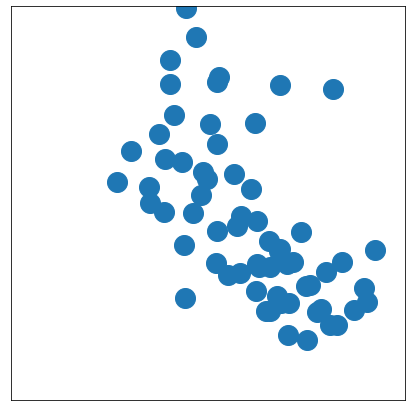

In [73]:
# Create a function to calculate the total energy
energy_fn = vanderwaals_cutoff_pair(displacement)

# Use this to calculate the total energy
print(energy_fn(R))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

# Minimize the energy using the FIRE algorithm
Rfinal, max_force_component = run_minimization(energy_fn, R, shift)
print("largest component of force after minimization = {}".format(max_force_component))
plot_system(Rfinal, BOX_SIZE)
